In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
#from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [3]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = 'train'
valid_path = 'val'
test_path = 'test'

In [4]:
# useful for getting number of output classes
folders = glob('train/*')

In [5]:
folders

['train\\Healthy', 'train\\Unhealthy']

In [6]:
# Import the Vgg 16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

vgg16 = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [7]:
# don't train existing weights
for layer in vgg16.layers:
    layer.trainable = False

In [8]:
# our layers - you can add more if you want
x = Flatten()(vgg16.output)

In [9]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg16.input, outputs=prediction)

In [10]:
# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [11]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [12]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [13]:
# Make sure you provide the same target size as initialied for the image size
train_generator = train_datagen.flow_from_directory('train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                                 ) # set as training data

Found 4693 images belonging to 2 classes.


In [14]:
valid_generator = train_datagen.flow_from_directory('val',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical') 

Found 1564 images belonging to 2 classes.


In [15]:
test_generator = test_datagen.flow_from_directory('test',
                                            target_size = (224, 224),
                                            batch_size = 1,
                                            class_mode = 'categorical',
                                            ) 

Found 1564 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
earlystopper=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=1,
    mode='auto', baseline=None, restore_best_weights=False
)

In [16]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  train_generator,
  validation_data=valid_generator,
  epochs=5,
  steps_per_epoch=len(train_generator),
  validation_steps=len(valid_generator),
  callbacks = [earlystopper]
)

C:\Users\DELL\anaconda3\envs\marzharenv\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
147/147 [==============================] - 81s 514ms/step - loss: 0.1172 - accuracy: 0.9572 - val_loss: 0.0132 - val_accuracy: 1.0000
Epoch 2/5
147/147 [==============================] - 72s 489ms/step - loss: 0.0090 - accuracy: 0.9996 - val_loss: 0.0065 - val_accuracy: 1.0000
Epoch 3/5
147/147 [==============================] - 72s 490ms/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.0042 - val_accuracy: 1.0000
Epoch 4/5
147/147 [==============================] - 74s 501ms/step - loss: 0.0034 - accuracy: 0.9998 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 5/5
147/147 [==============================] - 74s 504ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0019 - val_accuracy: 1.0000


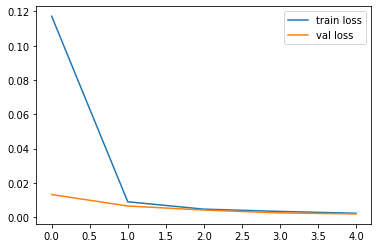

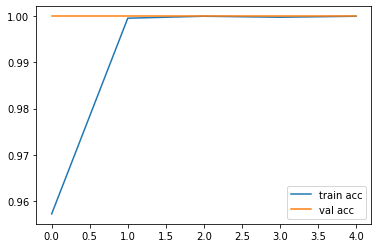

<Figure size 432x288 with 0 Axes>

In [18]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [19]:
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print('\nTest accuracy:', test_acc)
print('\nTest loss:', test_loss)

1564/1564 - 14s - loss: 0.0017 - accuracy: 1.0000

Test accuracy: 1.0

Test loss: 0.0017310593975707889


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
test_generator.reset()
# get the ground truth of your data. 
y_true = test_generator.classes 

# predict the probability distribution of the data
predictions = model.predict(test_generator, verbose=2)

# get the class with highest probability for each sample
y_pred = np.argmax(predictions, axis=1)

# get the classification report
print(classification_report(y_true, y_pred))

In [ ]:
print(confusion_matrix(y_true, y_pred)

In [ ]:
from tensorflow.keras.models import load_model

model.save('logs/model_vgg16.h5')

test accuracy : 100.0


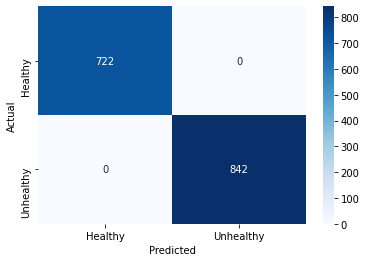

In [20]:
import pandas as pd
import seaborn as sn
import tensorflow as tf

model = tf.keras.models.load_model('logs/model_vgg16.h5')
filenames = test_generator.filenames
nb_samples = len(test_generator)
y_prob=[]
y_act=[]
test_generator.reset()
for _ in range(nb_samples):
   X_test,Y_test = test_generator.next()
   y_prob.append(model.predict(X_test))
   y_act.append(Y_test)

predicted_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_prob]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_act]

out_df = pd.DataFrame(np.vstack([predicted_class,actual_class]).T,columns=['predicted_class','actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'],out_df['predicted_class'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix,cmap='Blues', annot=True,fmt='d')
plt.show
print('test accuracy : {}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))